In [436]:
# get tuned alg results for each split separately

import pandas as pd
import numpy as np

metadataset_df = pd.read_csv("./results/tuned_fold_results.csv")


# Develop outcome measures for each dataset split

In [2]:
# categorize each alg

neural_algs = [
    "MLP",
    "TabNet",
    "VIME",
    "TabTransformer",
    "NODE",
    "STG",
    "NAM",
    "DeepFM",
    "SAINT",
    "DANet",
    "rtdl_MLP",
    "rtdl_ResNet",
    "rtdl_FTTransformer",
    "TabPFNModel"
]

tree_algs = [
    "LightGBM",
    "XGBoost",
    "CatBoost",
    "RandomForest",

]

baseline_algs = [
    "DecisionTree",
    "LinearModel",
    "KNN",
    "SVM",
]

metadataset_df.loc[:, "alg_type"] = "baseline"
metadataset_df.loc[metadataset_df["alg_name"].isin(neural_algs), "alg_type"] = "neural"
metadataset_df.loc[metadataset_df["alg_name"].isin(tree_algs), "alg_type"] = "trees"

print(metadataset_df.groupby("alg_type")["alg_name"].value_counts())

alg_type  alg_name          
baseline  DecisionTree          1710
          LinearModel           1670
          KNN                   1640
          SVM                   1430
neural    rtdl_MLP              1710
          MLP                   1700
          rtdl_ResNet           1700
          TabNet                1660
          STG                   1630
          VIME                  1620
          DANet                 1470
          rtdl_FTTransformer    1390
          NODE                  1380
          TabTransformer        1220
          SAINT                 1060
          DeepFM                 900
          NAM                    800
          TabPFNModel            630
trees     XGBoost               1710
          RandomForest          1700
          LightGBM              1640
          CatBoost              1630
Name: alg_name, dtype: int64


## Clean metafeatures
- remove feats with nan
- remove redundant features (those with eqaul values for all datasets)

In [215]:
from metadata_utils import process_metafeatures

metafeatures_df = pd.read_csv("../TabSurvey/metafeatures.csv")
metafeatures_processed = process_metafeatures(metafeatures_df, filter_families=None)


/Users/duncan/research/active_projects/tabzilla/tabzilla_analysis/metadata_utils.py:56: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  metafeatures_processed = metafeatures_df.fillna(metafeatures_df.median())


In [257]:
def cor(x, y):
    return np.corrcoef(x, y)[0, 1]

In [10]:

all_feature_cols = [c for c in metafeatures_df.columns if c.startswith("f__")]

# no_nan_metafeatures = metafeatures_df[all_feature_cols].isna().sum() == 0
# print(f"number of metafeatures with no nans: {sum(no_nan_metafeatures)}")
# print(f"number of metafeatures with nans:    {sum(~no_nan_metafeatures)}")

# get features with no NaNs
# no_nan_feats = list(no_nan_metafeatures[no_nan_metafeatures].index)

# find and remove/record redundant features
redundant_feats = []
for i, feat in enumerate(all_feature_cols):
    if feat in redundant_feats:
        continue
    for j in range(i + 1, len(all_feature_cols)):
        if (metafeatures_processed[feat] == metafeatures_processed[all_feature_cols[j]]).all():
            print(f"removing feat: {all_feature_cols[j]} (equal to {feat}")
            redundant_feats.append(all_feature_cols[j])
        elif cor(metafeatures_processed[feat].values, metafeatures_processed[all_feature_cols[j]].values) > 0.999:
            print(f"removing feat: {all_feature_cols[j]} (corr with {feat}")
            redundant_feats.append(all_feature_cols[j])

redundant_feats = list(set(redundant_feats))

print(f"removing {len(redundant_feats)} redundant features:")
# for f in redundant_feats: print(f)

# keep only features which have no NaNs and are not redundant
keep_feats = [f for f in all_feature_cols if f not in redundant_feats]

# final dataset
keep_metafeatures_df = metafeatures_processed.loc[:, ["dataset_name"] + keep_feats]

keep_metafeatures_df.loc[:, "dataset_family"] = keep_metafeatures_df["dataset_name"].apply(lambda x: x[:-len("__fold_x")])

/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


removing feat: f__pymfe.landmarking.elite_nn.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.linear_discr.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.naive_bayes.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.one_nn.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.random_node.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.worst_node.count (equal to f__pymfe.landmarking.best_node.count


/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/numpy/lib/function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


removing feat: f__pymfe.relative.best_node.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.elite_nn.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.linear_discr.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.naive_bayes.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.one_nn.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.random_node.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.worst_node.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.elite_nn.count.relative (equal to f__pymfe.landmarking.best_node.count.relative
removing feat: f__pymfe.landmarking.linear_discr.count.relative (equal to f__pymfe.landmarking.best_node.count.relative
removing feat: f__pymfe.landmarking.naive_bayes.count.relative (equal to f__pymfe.landma

In [35]:
# save this as "cleaned" metafeatures
keep_metafeatures_df.to_csv("./results/cleaned_metafeatures.csv", index="dataset_name")

In [3]:
################
# IF CLEANED METAFEATURES HAS ALREADY BEEN WRITTEN
keep_metafeatures_df = pd.read_csv("./results/cleaned_metafeatures.csv", index_col=0)

# drop cols that are all NaN

# keep_metafeatures_df.loc[keep_metafeatures_df.isna().sum() > 0, :]
na_feats = keep_metafeatures_df.isna().sum() == len(keep_metafeatures_df)
na_feat_names = list(na_feats[na_feats].index)
print(f"dropping cols with only NA: {na_feat_names}")
keep_metafeatures_df.drop(columns=na_feat_names, inplace=True)

# replace inf with something else
keep_metafeatures_df.replace([np.inf, -np.inf], 0.0, inplace=True)

dropping cols with only NA: ['f__pymfe.statistical.iq_range', 'f__pymfe.statistical.t_mean']


In [413]:
keep_metafeatures_df.head()

,dataset_name,f__pymfe.landmarking.best_node.count,f__pymfe.landmarking.best_node.count.relative,f__pymfe.landmarking.best_node.histogram.0,f__pymfe.landmarking.best_node.histogram.0.relative,f__pymfe.landmarking.best_node.histogram.1,f__pymfe.landmarking.best_node.histogram.1.relative,f__pymfe.landmarking.best_node.histogram.2,f__pymfe.landmarking.best_node.histogram.2.relative,f__pymfe.landmarking.best_node.histogram.3,...,f__pymfe.info-theory.joint_ent.quantiles.1_LOG,f__pymfe.info-theory.joint_ent.quantiles.3_LOG,f__pymfe.info-theory.joint_ent.sd_LOG,f__pymfe.info-theory.mut_inf.max_LOG,f__pymfe.info-theory.mut_inf.mean_LOG,f__pymfe.info-theory.mut_inf.median_LOG,f__pymfe.info-theory.mut_inf.quantiles.1_LOG,f__pymfe.info-theory.mut_inf.quantiles.3_LOG,f__pymfe.info-theory.mut_inf.sd_LOG,f__pymfe.info-theory.ns_ratio_LOG
0,openml__cjs__14967__fold_0,10,4.0,0.3,6.5,0.0,2.5,0.2,6.5,0.2,...,1.705904,1.713303,-2.850165,0.924285,0.256894,0.256894,-0.386648,0.645262,0.551273,0.843937
1,openml__cjs__14967__fold_1,10,4.0,0.1,4.0,0.0,3.0,0.0,2.5,0.2,...,1.707468,1.715503,-2.765918,0.924285,0.255784,0.255784,-0.389819,0.644886,0.552441,0.848505
2,openml__cjs__14967__fold_2,10,4.0,0.3,7.0,0.1,5.5,0.1,4.5,0.0,...,1.706839,1.716313,-2.601080,0.924285,0.259687,0.259687,-0.378697,0.646210,0.548323,0.844776
3,openml__cjs__14967__fold_3,10,4.0,0.1,3.5,0.1,4.5,0.1,6.0,0.3,...,1.704818,1.714427,-2.588951,0.924445,0.261847,0.261847,-0.372867,0.647050,0.546359,0.838894
4,openml__cjs__14967__fold_4,10,4.0,0.1,3.5,0.1,6.5,0.1,5.5,0.4,...,1.706112,1.713506,-2.850776,0.924500,0.258184,0.258184,-0.383368,0.645842,0.550355,0.842844


## merge performance dataset with metafeatures

In [432]:
# get best-performing alg type for each dataset split
best_alg_df_dict = {}
neural_tree_diff_dict = {}

metric_list = [
    "Accuracy",
    "F1",
    "Log Loss",
]

obj_type_list = [
    "max",
    "max",
    "min",
]

for metric, obj_type in zip(metric_list, obj_type_list):

    ####################################################################################
    # get the difference in metric between the best neural and tree alg for each dataset
    if obj_type == "max":
        tree_best = metadataset_df[metadataset_df["alg_type"] == "trees"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .max().reset_index()
        neural_best = metadataset_df[metadataset_df["alg_type"] == "neural"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .max().reset_index()
        baseline_best = metadataset_df[metadataset_df["alg_type"] == "baseline"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .max().reset_index()
    elif obj_type == "min":
        tree_best = metadataset_df[metadataset_df["alg_type"] == "trees"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .min().reset_index()
        neural_best = metadataset_df[metadataset_df["alg_type"] == "neural"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .min().reset_index()
        baseline_best = metadataset_df[metadataset_df["alg_type"] == "baseline"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .min().reset_index()

    # merge these and get the difference & abs-difference
    baseline_best.rename(columns={f"normalized_{metric}__test": f"normalized_{metric}__test_baseline"}, inplace=True)
    neural_tree_diff = neural_best.merge(tree_best, on="dataset_fold_id", suffixes=["_neural", "_trees"], how="inner").merge(baseline_best, on="dataset_fold_id")

    neural_tree_diff.loc[:, "neural_tree_diff"] = neural_tree_diff[f"normalized_{metric}__test_neural"] - neural_tree_diff[f"normalized_{metric}__test_trees"]
    neural_tree_diff.loc[:, "abs_neural_tree_diff"] = neural_tree_diff.loc[:, "neural_tree_diff"].abs()

    neural_tree_diff_dict[metric] = neural_tree_diff

    #################################
    # # define the "top-ranked" algs

    # df_metric = metadataset_df.loc[metadataset_df[f"{metric}_rank"] == 1, :]
    df_metric = metadataset_df.loc[metadataset_df[f"normalized_{metric}__test"] >= 0.99, :]

    # get a list of all top-ranked algs for each dataset split
    best_algs = df_metric.groupby("dataset_fold_id")["alg_type"].apply(lambda x: set(x)).reset_index()

    # add a binary col indicating whether best alg includes each alg class
    for alg_type in ["trees", "neural", "baseline"]:
        best_algs.loc[:, f"{alg_type}_win"] = best_algs["alg_type"].apply(lambda x: 1 if alg_type in x else 0)

    best_alg_df_dict[metric] = best_algs

In [433]:
# len(best_alg_df_dict["Accuracy"]["dataset_fold_id"].unique()) # 1705
set(metadataset_df["dataset_fold_id"].unique()).difference(best_alg_df_dict["Accuracy"]["dataset_fold_id"].unique())

# which folds are missing?

{'openml__postoperative-patient-data__146210__fold_7',
 'openml__rabe_266__3647__fold_7',
 'openml__solar-flare__2068__fold_0',
 'openml__solar-flare__2068__fold_1',
 'openml__solar-flare__2068__fold_8'}

In [434]:
# there are errors with these splits.

In [435]:
# merge on dataset split name
for metric in metric_list:
    neural_tree_diff_dict[metric] = neural_tree_diff_dict[metric].merge(keep_metafeatures_df, left_on="dataset_fold_id", right_on="dataset_name", how="left")
    best_alg_df_dict[metric] = best_alg_df_dict[metric].merge(keep_metafeatures_df, left_on="dataset_fold_id", right_on="dataset_name", how="left")

### Basic analysis of winningest algs

In [418]:
metric = "Accuracy"
df = best_alg_df_dict[metric]

winning_alg_counts = df["alg_type"].value_counts().rename("Num. Wins").reset_index()
winning_alg_counts.loc[:, "pct"] = (100 * winning_alg_counts["Num. Wins"] / winning_alg_counts["Num. Wins"].sum()).round(1)
print(winning_alg_counts.to_latex(index=False))
print(f"total splits: {winning_alg_counts['Num. Wins'].sum()}")

print(f"total tree wins: {df['trees_win'].sum()} ({100. * df['trees_win'].sum()/len(df)})")
print(f"total neural wins: {df['neural_win'].sum()} ({100. * df['neural_win'].sum()/len(df)})")
print(f"total baseline wins: {df['baseline_win'].sum()} ({100. * df['baseline_win'].sum()/len(df)})")

\begin{tabular}{lrr}
\toprule
                    index &  Num. Wins &  pct \\
\midrule
                  \{trees\} &        512 & 30.0 \\
                 \{neural\} &        432 & 25.3 \\
\{neural, trees, baseline\} &        270 & 15.8 \\
          \{neural, trees\} &        208 & 12.2 \\
       \{neural, baseline\} &        128 &  7.5 \\
               \{baseline\} &        115 &  6.7 \\
        \{trees, baseline\} &         40 &  2.3 \\
\bottomrule
\end{tabular}

total splits: 1705
total tree wins: 1030 (60.410557184750736)
total neural wins: 1038 (60.87976539589443)
total baseline wins: 553 (32.43401759530792)


/var/folders/mv/xx16lc8s74g35q1kd_93l7_w0000gn/T/ipykernel_3481/3173636966.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(winning_alg_counts.to_latex(index=False))


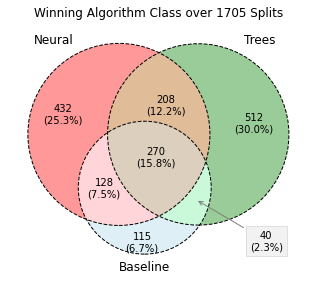

In [419]:
# plot the above as a venn diagram
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

fix, ax = plt.subplots(figsize=(4.5, 4.5))
# ordering of subsets is (Abc, aBc, ABc, abC, AbC, aBC, ABC)
# here, A = Neural, B = Trees, C = Baseline
Abc = winning_alg_counts[winning_alg_counts["index"] == {'neural'}]["Num. Wins"].values[0]
aBc = winning_alg_counts[winning_alg_counts["index"] == {'trees'}]["Num. Wins"].values[0]
abC = winning_alg_counts[winning_alg_counts["index"] == {'baseline'}]["Num. Wins"].values[0]
ABc = winning_alg_counts[winning_alg_counts["index"] == {'trees', 'neural'}]["Num. Wins"].values[0]
aBC = winning_alg_counts[winning_alg_counts["index"] == {'trees', 'baseline'}]["Num. Wins"].values[0]
AbC = winning_alg_counts[winning_alg_counts["index"] == {'neural', 'baseline'}]["Num. Wins"].values[0]
ABC = winning_alg_counts[winning_alg_counts["index"] == {'neural', 'trees', 'baseline'}]["Num. Wins"].values[0]

Abc_text = f"{Abc}\n({np.round(100. * Abc / len(df),1):.1f}%)"
aBc_text = f"{aBc}\n({np.round(100. * aBc / len(df),1):.1f}%)"
abC_text = f"{abC}\n({np.round(100. * abC / len(df),1):.1f}%)"
ABc_text = f"{ABc}\n({np.round(100. * ABc / len(df),1):.1f}%)"
AbC_text = f"{AbC}\n({np.round(100. * AbC / len(df),1):.1f}%)"
aBC_text = f"{aBC}\n({np.round(100. * aBC / len(df),1):.1f}%)"
ABC_text = f"{ABC}\n({np.round(100. * ABC / len(df),1):.1f}%)"

v = venn3(subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC), set_labels=('Neural', 'Trees', 'Baseline'), ax=ax, set_colors=('r', 'g', 'lightblue'))
c = venn3_circles(subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC), linestyle='dashed', linewidth=1.0)

v.get_label_by_id('100').set_text(Abc_text)
v.get_label_by_id('010').set_text(aBc_text)
v.get_label_by_id('001').set_text(abC_text)
v.get_label_by_id('110').set_text(ABc_text)
v.get_label_by_id('101').set_text(AbC_text) 
v.get_label_by_id('011').set_text("")  # moved outside of box
v.get_label_by_id('111').set_text(ABC_text)


# v.get_patch_by_id('100').set_weight("bold")
# v.get_label_by_id('010').set_text(aBc_text)
# v.get_label_by_id('001').set_text(abC_text)
# v.get_label_by_id('110').set_text(ABc_text)
# v.get_label_by_id('101').set_text(AbC_text) 
# v.get_label_by_id('011').set_text("")  # moved outside of box
# v.get_label_by_id('111').set_text(ABC_text)


# v.get_patch_by_id('001').set_color("gray")

# # move AbC_text outside of box
# ax.annotate(AbC_text, xy=v.get_label_by_id('101').get_position() - np.array([0, 0.05]), xytext=(-70,-35),
#              ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
#              arrowprops=dict(arrowstyle='->', color='gray'))

# move aBC_text outside of box
ax.annotate(aBC_text, xy=v.get_label_by_id('011').get_position() - np.array([0, 0.00]), xytext=(70,-50),
             ha='center', textcoords='offset points', bbox=dict(fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->',color='gray'))


ax.set_title("Winning Algorithm Class over 1705 Splits")

plt.tight_layout()
plt.savefig("./results/winning_venn.pdf", bbox_inches=0)

# Q1: when do neural and tree algs have different performance?

In [420]:
metric = "Accuracy"

df_q1 = neural_tree_diff_dict[metric]

# df_q1 = df_q1.loc[df_q1["abs_neural_tree_diff"] > 0.05, :]

# drop rows where the diff is nan
df_q1.drop(index=df_q1.loc[df_q1["neural_tree_diff"].isna(), :].index, inplace=True)

# drop rows where baseline also wins
# df_q1.drop(index=df_q1.loc[df_q1[f"normalized_{metric}__test_baseline"] >= 0.99, :].index, inplace=True)

def simplify(x):
    return x.replace("statistical", "stat").replace("model-based", "model").replace("landmarking", "landmark").replace("skewness", "skew")

feature_cols = [c for c in df_q1.columns if c.startswith("f__")]
nice_feature_names = [simplify(f[len("f__pymfe."):]) for f in feature_cols]
print(df_q1.head())

                      dataset_fold_id  normalized_Accuracy__test_neural  \
0  openml__APSFailure__168868__fold_0                          0.931373   
1  openml__APSFailure__168868__fold_1                          0.770115   
2  openml__APSFailure__168868__fold_2                          0.912088   
3  openml__APSFailure__168868__fold_3                          0.944444   
4  openml__APSFailure__168868__fold_4                          0.857143   

   normalized_Accuracy__test_trees  normalized_Accuracy__test_baseline  \
0                              1.0                            0.715686   
1                              1.0                            0.712644   
2                              1.0                            0.659341   
3                              1.0                            0.878307   
4                              1.0                            0.647619   

   neural_tree_diff  abs_neural_tree_diff                        dataset_name  \
0         -0.068627    

In [390]:
# # fit lasso model to find features most-correlated with abs-diff beteween neural and tree performance

# from sklearn.linear_model import LassoCV
# from sklearn.linear_model import LogisticRegression

# # target_col = "abs_neural_tree_diff"
# # feature_cols = [c for c in df.columns if c.startswith("f__")]
# # nice_feature_names = [f[len("f__pymfe."):] for f in feature_cols]

# # x = df.loc[:, feature_cols]
# # y = df.loc[:, target_col]

# # # drop rows with y = na
# # non_na_cols = ~y.isna()

# # x_keep = x.loc[non_na_cols, :]
# # y_keep = y[non_na_cols]

# lasso_q1 = LassoCV(cv=5, random_state=0, verbose=True, max_iter=5000).fit(
#     df_q1[feature_cols].clip(-1e10, 1e10), 
#     df_q1["neural_tree_diff"].clip(-1e10, 1e10),
#     )
# # lasso_q1 = LogisticRegression(penalty="l1", solver="saga", max_iter=5000, C=1e1).fit(x, y)


# print("lasso-identified features:")
# abs_coef = np.abs(lasso_q1.coef_)

# idx_sorted_lasso = (-abs_coef).argsort()
# # threshold = importance[idx_third] + 0.01

# num_print_feats = 10

# for i in range(num_print_feats):
#     print(f"{nice_feature_names[idx_sorted_lasso[i]]}: {abs_coef[idx_sorted_lasso[i]]}")
# # for 
# # # 
# # idx_features = (-importance).argsort()
# # name_features = np.array(feature_names)[idx_features]
# # print('Selected features: {}'.format(name_features))

# Ablation on meta-features for predicting difference between neural and tree methods

In [421]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

metric = "Accuracy"

scaler = RobustScaler()
y = neural_tree_diff_dict[metric].loc[:, "neural_tree_diff"]
x = scaler.fit_transform(neural_tree_diff_dict[metric].loc[:, feature_cols].values.clip(-1e10, 1e10))

In [423]:
# decision tree ablation study by depth

from sklearn import tree, metrics

# get dataset names
dataset_basename = neural_tree_diff_dict[metric]["dataset_name"].apply(lambda x: "__".join(x.split("__")[1:3]))
all_datasets = dataset_basename.unique()

depth_list = list(range(1, 20, 2))
depth_feats = []
depth_mae = []
for i, depth in enumerate(depth_list):

    depth_mae_list = []
    depth_feat_imp_list = []
    for dataset in all_datasets:
            
        # create train-test splits based on dataset 
        test_ind = dataset_basename == dataset
        train_ind = ~train_ind

        x_train = x[train_ind, :]
        x_test = x[test_ind, :]

        y_train = y[train_ind]
        y_test = y[test_ind]

        # fit a tree with limited max depth
        clf = tree.DecisionTreeRegressor(max_depth=depth, min_samples_leaf=5).fit(x_train, y_train)
        depth_mae_list.append(metrics.mean_absolute_error(y_test, clf.predict(x_test)))

        depth_feat_imp_list.append(clf.feature_importances_)

    depth_feats.append(depth_feat_imp_list)
    depth_mae.append(depth_mae_list)
    print(f"depth={depth} | avg (std) MAE = {np.mean(depth_mae[i]):.5f} {np.std(depth_mae[i]):.5f} | num-feats = {np.sum(np.sum(depth_feats[i], axis=0) > 0)}")


# get features: 
# [feature_cols[i] for i in np.where(depth_clf[3].feature_importances_)[0]]


depth=1 | avg (std) MAE = 0.16215 0.10053 | num-feats = 3


KeyboardInterrupt: 

In [194]:
for i, depth in enumerate(depth_list):
    print(f"depth={depth} | avg (std) MAE = {np.mean(depth_mae[i]):.5f} {np.std(depth_mae[i]):.5f} | num-feats = {np.sum(np.sum(depth_feats[i], axis=0) > 0)}")


depth=1 | avg (std) MAE = 0.16489 0.10352 | num-feats = 3
depth=3 | avg (std) MAE = 0.15005 0.08437 | num-feats = 20
depth=5 | avg (std) MAE = 0.14884 0.10583 | num-feats = 112
depth=7 | avg (std) MAE = 0.13112 0.09132 | num-feats = 143
depth=9 | avg (std) MAE = 0.13756 0.10802 | num-feats = 211
depth=11 | avg (std) MAE = 0.12217 0.08978 | num-feats = 295
depth=13 | avg (std) MAE = 0.12924 0.10674 | num-feats = 365
depth=15 | avg (std) MAE = 0.11869 0.09726 | num-feats = 520
depth=17 | avg (std) MAE = 0.12234 0.10878 | num-feats = 544
depth=19 | avg (std) MAE = 0.11268 0.09671 | num-feats = 578


In [201]:
# now with no limit
depth=None

depth_mae_list = []
depth_feat_imp_list = []
for dataset in all_datasets:
        
    # create train-test splits based on dataset 
    test_ind = dataset_basename == dataset
    train_ind = ~train_ind

    x_train = x[train_ind, :]
    x_test = x[test_ind, :]

    y_train = y[train_ind]
    y_test = y[test_ind]

    # fit a tree with limited max depth
    clf = tree.DecisionTreeRegressor(max_depth=depth, min_samples_leaf=5).fit(x_train, y_train)
    depth_mae_list.append(metrics.mean_absolute_error(y_test, clf.predict(x_test)))

    depth_feat_imp_list.append(clf.feature_importances_)

print(f"depth={depth} | avg (std) MAE = {np.mean(depth_mae_list):.5f} ({np.std(depth_mae_list):.5f}) | num-feats = {np.sum(np.sum(depth_feat_imp_list, axis=0) > 0)}")

# find the most common features
feature_use_counts = np.sum(np.abs(depth_feat_imp_list) > 0, axis=0)
sorted_inds = (-feature_use_counts).argsort()
for j in range(10):
    print(f"{j + 1}: {feature_cols[sorted_inds[j]]} ({feature_use_counts[sorted_inds[j]]})")


depth=None | avg (std) MAE = 0.11908 (0.11099) | num-feats = 682
1: f__pymfe.model-based.leaves_branch.histogram.4 (129)
2: f__pymfe.general.freq_class.min (85)
3: f__pymfe.landmarking.naive_bayes.histogram.0.relative (85)
4: f__pymfe.model-based.nodes_per_level.histogram.6 (85)
5: f__pymfe.statistical.iq_range.histogram.1 (85)
6: f__pymfe.landmarking.naive_bayes.histogram.2.relative (85)
7: f__pymfe.statistical.iq_range.histogram.2 (85)
8: f__pymfe.model-based.nodes_per_attr (85)
9: f__pymfe.landmarking.naive_bayes.histogram.5 (85)
10: f__pymfe.landmarking.naive_bayes.histogram.6.relative (85)


In [216]:
# find the most common features selected at each depth
for i, depth in enumerate(depth_list):
    print(f"---- features for tree depth {depth} -----")
    # find the most common features
    feature_use_counts = np.sum(np.abs(depth_feats[i]) > 0, axis=0)
    feature_importance = np.mean(depth_feats[i], axis=0)
    sorted_inds = (-feature_importance).argsort()
    for j in range(10):
        print(f"{j + 1}: {feature_cols[sorted_inds[j]]} ({feature_importance[sorted_inds[j]]})")


---- features for tree depth 1 -----
1: f__pymfe.model-based.leaves_corrob.skewness (0.49707602339181284)
2: f__pymfe.model-based.leaves_branch.histogram.4 (0.28654970760233917)
3: f__pymfe.model-based.tree_imbalance.histogram.6 (0.21637426900584794)
4: f__pymfe.landmarking.best_node.count (0.0)
5: f__pymfe.statistical.t_mean.histogram.7 (0.0)
6: f__pymfe.statistical.t_mean.histogram.8 (0.0)
7: f__pymfe.statistical.t_mean.histogram.9 (0.0)
8: f__pymfe.statistical.t_mean.iq_range (0.0)
9: f__pymfe.statistical.t_mean.kurtosis (0.0)
10: f__pymfe.statistical.t_mean.median (0.0)
---- features for tree depth 3 -----
1: f__pymfe.model-based.leaves_branch.histogram.4 (0.2573099415204678)
2: f__pymfe.model-based.tree_imbalance.histogram.6 (0.23976608187134502)
3: f__pymfe.model-based.leaves_corrob.skewness (0.16209238433991835)
4: f__pymfe.statistical.can_cor.mean (0.12382917913356173)
5: f__pymfe.statistical.sd.histogram.9 (0.05402365265521822)
6: f__pymfe.model-based.leaves_corrob.histogram.9

In [203]:
# now use an xgbregressor...
from xgboost import XGBRegressor


xgb_mae_list = []
xgb_feat_imp_list = []
for dataset in all_datasets:
        
    # create train-test splits based on dataset 
    test_ind = dataset_basename == dataset
    train_ind = ~train_ind

    x_train = x[train_ind, :]
    x_test = x[test_ind, :]

    y_train = y[train_ind]
    y_test = y[test_ind]

    # fit a tree with limited max depth
    clf = XGBRegressor(n_estimators=150).fit(x_train, y_train)
    xgb_mae_list.append(metrics.mean_absolute_error(y_test, clf.predict(x_test)))

    xgb_feat_imp_list.append(clf.feature_importances_)

print(f"XGB | avg (std) MAE = {np.mean(xgb_mae_list):.5f} ({np.std(xgb_mae_list):.5f}) | num-feats = {np.sum(np.sum(xgb_feat_imp_list, axis=0) > 0)}")

# find the most importan features
feature_importance_mean = np.mean(xgb_feat_imp_list, axis=0)
sorted_inds = (-feature_importance_mean).argsort()
for j in range(10):
    print(f"{j + 1}: {feature_cols[sorted_inds[j]]} ({feature_importance_mean[sorted_inds[j]]})")


XGB | avg (std) MAE = 0.08432 (0.10049) | num-feats = 771
1: f__pymfe.model-based.leaves_branch.histogram.4 (129)
2: f__pymfe.general.freq_class.min (85)
3: f__pymfe.landmarking.naive_bayes.histogram.0.relative (85)
4: f__pymfe.model-based.nodes_per_level.histogram.6 (85)
5: f__pymfe.statistical.iq_range.histogram.1 (85)
6: f__pymfe.landmarking.naive_bayes.histogram.2.relative (85)
7: f__pymfe.statistical.iq_range.histogram.2 (85)
8: f__pymfe.model-based.nodes_per_attr (85)
9: f__pymfe.landmarking.naive_bayes.histogram.5 (85)
10: f__pymfe.landmarking.naive_bayes.histogram.6.relative (85)


## Ablation Study for Classifier - when do Nets/Trees win?

In [384]:
# use a multi-output classifier trinaed on {trees-win, nets-win, OTHER}
# (we define y for other outcomes as well, below)

# then maybe try a chained classifier


from sklearn.preprocessing import RobustScaler

metric = "Accuracy"

scaler = RobustScaler()
y = best_alg_df_dict[metric].loc[:, ["baseline_win", "trees_win", "neural_win"]].astype(int).values
y_baseline = best_alg_df_dict[metric].loc[:, "baseline_win"].astype(int).values

# 1 = neural win, -1 = trees win, 0 = other
y_neural_vs_tree = ((best_alg_df_dict[metric]["neural_win"].astype(int) - best_alg_df_dict[metric]["trees_win"].astype(int)) \
    * (1 - best_alg_df_dict[metric]["baseline_win"].astype(int))).values

# 2 = neural win (trees dont), 0 = trees win (neural doesn't), 1 = other
y_neural_xor_tree = 1 + (best_alg_df_dict[metric]["neural_win"].astype(int) - best_alg_df_dict[metric]["trees_win"].astype(int)).values

# 1 = diff of normalized performance > 0.1 between nets & trees, 0 = otherwise
y_neural_tree_diff = (neural_tree_diff_dict[metric].loc[:, "abs_neural_tree_diff"] > 0.1).values

# 1 = neural > tree, 0 = otherwise
y_neural_beats_tree = (neural_tree_diff_dict[metric].loc[:, "neural_tree_diff"] > 0.0).values


x = best_alg_df_dict[metric].loc[:, feature_cols].values.clip(-1e10, 1e10)

In [385]:
# pd.value_counts(y_neural_tree_diff)
pd.value_counts(y_neural_beats_tree)


False    1042
True      663
dtype: int64

In [339]:
## now fit a classification model for a three-way classification problem: {nets-win, trees-win, }
# decision tree ablation study by depth

from sklearn.multioutput import MultiOutputClassifier
from sklearn import tree, metrics

# get dataset names
dataset_basename = best_alg_df_dict[metric]["dataset_name"].apply(lambda x: "__".join(x.split("__")[1:3]))
all_datasets = dataset_basename.unique()

class_depth_list = list(range(1, 17, 2)) + [None]
class_depth_feats = []
class_depth_acc = []
for i, depth in enumerate(class_depth_list):

    depth_acc_list = []
    depth_feat_imp_list = []
    for dataset in all_datasets:
            
        # create train-test splits based on dataset 
        test_ind = dataset_basename == dataset
        train_ind = ~train_ind

        x_train = x[train_ind, :]
        x_test = x[test_ind, :]

        y_train = y_neural_tree_diff[train_ind]
        y_test = y_neural_tree_diff[test_ind]

        # fit a tree with limited max depth
        clf = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5).fit(x_train, y_train)
        # clf = MultiOutputClassifier(base_classifier).fit(x_train, y_train)
        depth_acc_list.append(metrics.accuracy_score(y_test, clf.predict(x_test)))

        depth_feat_imp_list.append(clf.feature_importances_)

    class_depth_feats.append(depth_feat_imp_list)
    class_depth_acc.append(depth_acc_list)
    print(f"depth={depth} | avg (std) Acc = {np.mean(class_depth_acc[i]):.5f} {np.std(class_depth_acc[i]):.5f} | num-feats = {np.sum(np.sum(class_depth_feats[i], axis=0) > 0)}")


# get features: 
# [feature_cols[i] for i in np.where(depth_clf[3].feature_importances_)[0]]


depth=1 | avg (std) Acc = 0.56256 0.32537 | num-feats = 16
depth=3 | avg (std) Acc = 0.61197 0.31677 | num-feats = 21
depth=5 | avg (std) Acc = 0.64333 0.32011 | num-feats = 142
depth=7 | avg (std) Acc = 0.66049 0.30097 | num-feats = 328
depth=9 | avg (std) Acc = 0.65223 0.35090 | num-feats = 387
depth=11 | avg (std) Acc = 0.71137 0.31608 | num-feats = 508
depth=13 | avg (std) Acc = 0.69258 0.32737 | num-feats = 513
depth=15 | avg (std) Acc = 0.71611 0.31118 | num-feats = 536
depth=None | avg (std) Acc = 0.69668 0.33495 | num-feats = 547


In [372]:
# train a single tree of max-depth 5 to visualize
clf_display = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=5).fit(x, y_neural_tree_diff)

In [373]:
clf_display.classes_

array([False,  True])

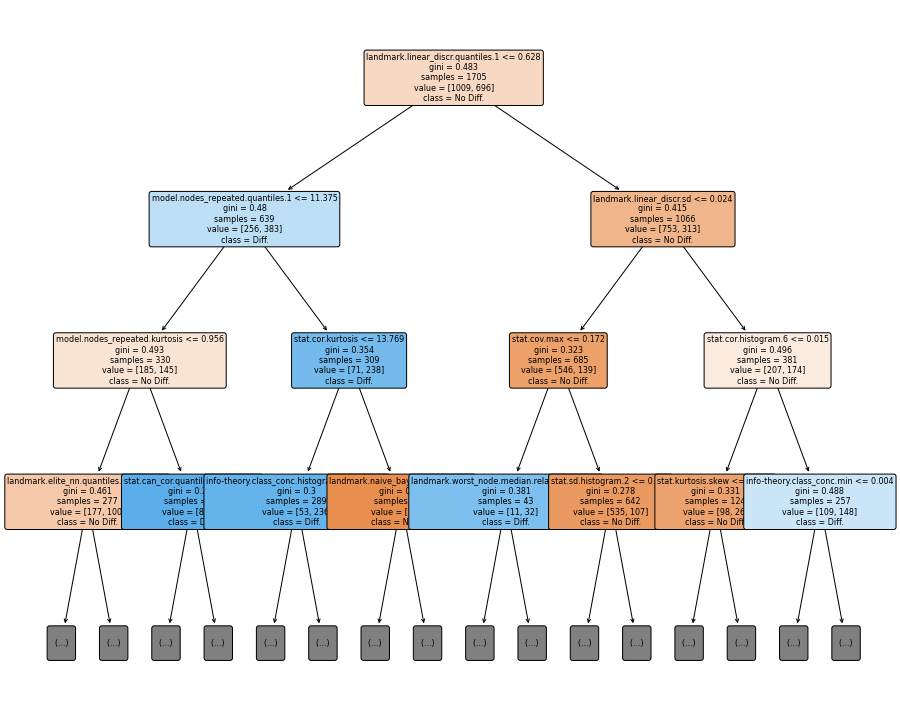

In [381]:
fig, ax = plt.subplots(1, 1, figsize=(15, 13))

annotations = tree.plot_tree(
    clf_display, 
    max_depth=3, 
    feature_names=nice_feature_names, 
    class_names=["No Diff.", "Diff."], 
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()

In [340]:
# ## now fit a classification model for a three-way classification problem: {nets-win, trees-win, }
# # decision tree ablation study by depth

# from sklearn.multioutput import MultiOutputClassifier
# from sklearn import tree, metrics

# # get dataset names
# dataset_basename = best_alg_df_dict[metric]["dataset_name"].apply(lambda x: "__".join(x.split("__")[1:3]))
# all_datasets = dataset_basename.unique()

# class_depth_list = list(range(1, 15, 2)) + [None]
# class_depth_feats = []
# class_depth_acc = []
# for i, depth in enumerate(class_depth_list):

#     depth_acc_list = []
#     depth_feat_imp_list = []
#     for dataset in all_datasets:
            
#         # create train-test splits based on dataset 
#         test_ind = dataset_basename == dataset
#         train_ind = ~train_ind

#         x_train = x[train_ind, :]
#         x_test = x[test_ind, :]

#         y_train = y_neural_xor_tree[train_ind]
#         y_test = y_neural_xor_tree[test_ind]

#         # fit a tree with limited max depth
#         clf = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5).fit(x_train, y_train)
#         # clf = MultiOutputClassifier(base_classifier).fit(x_train, y_train)
#         depth_acc_list.append(metrics.accuracy_score(y_test, clf.predict(x_test)))

#         depth_feat_imp_list.append(clf.feature_importances_)

#     class_depth_feats.append(depth_feat_imp_list)
#     class_depth_acc.append(depth_acc_list)
#     print(f"depth={depth} | avg (std) Acc = {np.mean(class_depth_acc[i]):.5f} {np.std(class_depth_acc[i]):.5f} | num-feats = {np.sum(np.sum(class_depth_feats[i], axis=0) > 0)}")


# # get features: 
# # [feature_cols[i] for i in np.where(depth_clf[3].feature_importances_)[0]]


In [344]:
# now use an xgbregressor...
from xgboost import XGBClassifier

class_xgb_acc_list = []
class_xgb_feat_imp_list = []
for dataset in all_datasets:
        
    # create train-test splits based on dataset 
    test_ind = dataset_basename == dataset
    train_ind = ~train_ind

    x_train = x[train_ind, :]
    x_test = x[test_ind, :]

    y_train = y_neural_tree_diff[train_ind]
    y_test = y_neural_tree_diff[test_ind]

    # fit a tree with limited max depth
    clf = XGBClassifier(n_estimators=150, use_label_encoder=False, eval_metric="logloss").fit(x_train, y_train)
    class_xgb_acc_list.append(metrics.accuracy_score(y_test, clf.predict(x_test)))

    class_xgb_feat_imp_list.append(clf.feature_importances_)

print(f"XGB | avg (std) Acc = {np.mean(class_xgb_acc_list):.5f} ({np.std(class_xgb_acc_list):.5f}) | num-feats = {np.sum(np.sum(xgb_feat_imp_list, axis=0) > 0)}")

# find the most importan features
feature_importance_mean = np.mean(class_xgb_feat_imp_list, axis=0)
sorted_inds = (-feature_importance_mean).argsort()
for j in range(10):
    print(f"{j + 1}: {feature_cols[sorted_inds[j]]} ({feature_importance_mean[sorted_inds[j]]})")


XGB | avg (std) Acc = 0.72247 (0.37404) | num-feats = 771
1: f__pymfe.landmarking.one_nn.histogram.8.relative (0.20355670154094696)
2: f__pymfe.landmarking.best_node.histogram.4.relative (0.0953124612569809)
3: f__pymfe.landmarking.best_node.histogram.7 (0.07994198054075241)
4: f__pymfe.landmarking.best_node.kurtosis (0.06782194972038269)
5: f__pymfe.landmarking.best_node.range (0.05704044923186302)
6: f__pymfe.landmarking.linear_discr.quantiles.1 (0.015501379035413265)
7: f__pymfe.model-based.nodes_per_attr (0.010071815922856331)
8: f__pymfe.statistical.sd.histogram.2 (0.00974983535706997)
9: f__pymfe.statistical.can_cor.max (0.008862951770424843)
10: f__pymfe.statistical.cov.max (0.00849947053939104)


### tree model for whether neural beats tree

In [386]:
## now fit a classification model for a three-way classification problem: {nets-win, trees-win, }
# decision tree ablation study by depth

from sklearn.multioutput import MultiOutputClassifier
from sklearn import tree, metrics

# get dataset names
dataset_basename = best_alg_df_dict[metric]["dataset_name"].apply(lambda x: "__".join(x.split("__")[1:3]))
all_datasets = dataset_basename.unique()

depth_list = list(range(1, 17, 2)) + [None]
neuralbeattree_depth_feats = []
neuralbeattree_depth_acc = []
for i, depth in enumerate(class_depth_list):

    depth_acc_list = []
    depth_feat_imp_list = []
    for dataset in all_datasets:
            
        # create train-test splits based on dataset 
        test_ind = dataset_basename == dataset
        train_ind = ~train_ind

        x_train = x[train_ind, :]
        x_test = x[test_ind, :]

        y_train = y_neural_beats_tree[train_ind]
        y_test = y_neural_beats_tree[test_ind]

        # fit a tree with limited max depth
        clf = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5).fit(x_train, y_train)
        # clf = MultiOutputClassifier(base_classifier).fit(x_train, y_train)
        depth_acc_list.append(metrics.accuracy_score(y_test, clf.predict(x_test)))

        depth_feat_imp_list.append(clf.feature_importances_)

    neuralbeattree_depth_feats.append(depth_feat_imp_list)
    neuralbeattree_depth_acc.append(depth_acc_list)
    print(f"depth={depth} | avg (std) Acc = {np.mean(neuralbeattree_depth_acc[i]):.5f} {np.std(neuralbeattree_depth_acc[i]):.5f} | num-feats = {np.sum(np.sum(neuralbeattree_depth_feats[i], axis=0) > 0)}")


# get features: 
# [feature_cols[i] for i in np.where(depth_clf[3].feature_importances_)[0]]


depth=1 | avg (std) Acc = 0.54263 0.27852 | num-feats = 3
depth=3 | avg (std) Acc = 0.59655 0.29401 | num-feats = 21
depth=5 | avg (std) Acc = 0.59351 0.27921 | num-feats = 183
depth=7 | avg (std) Acc = 0.63579 0.29036 | num-feats = 382
depth=9 | avg (std) Acc = 0.65784 0.27366 | num-feats = 423
depth=11 | avg (std) Acc = 0.65509 0.30036 | num-feats = 529
depth=13 | avg (std) Acc = 0.64965 0.29236 | num-feats = 561
depth=15 | avg (std) Acc = 0.67673 0.29567 | num-feats = 594
depth=None | avg (std) Acc = 0.67446 0.29591 | num-feats = 685


In [389]:
for i, depth in enumerate(class_depth_list):
    print(f"depth={depth} & {np.mean(neuralbeattree_depth_acc[i]):.2f}\\pm{np.std(neuralbeattree_depth_acc[i]):.2f} & {np.sum(np.sum(neuralbeattree_depth_feats[i], axis=0) > 0)}")


depth=1 & 0.54\pm0.28 & 3
depth=3 & 0.60\pm0.29 & 21
depth=5 & 0.59\pm0.28 & 183
depth=7 & 0.64\pm0.29 & 382
depth=9 & 0.66\pm0.27 & 423
depth=11 & 0.66\pm0.30 & 529
depth=13 & 0.65\pm0.29 & 561
depth=15 & 0.68\pm0.30 & 594
depth=None & 0.67\pm0.30 & 685


In [390]:
# train a single tree of max-depth 5 to visualize
clf_display = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=5).fit(x, y_neural_beats_tree)

In [391]:
clf_display.classes_

array([False,  True])

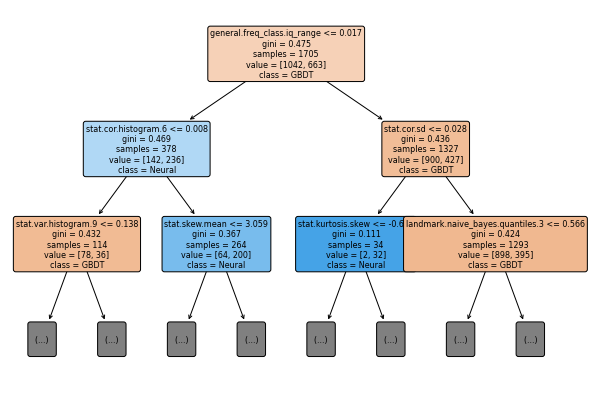

In [396]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

annotations = tree.plot_tree(
    clf_display, 
    max_depth=2, 
    feature_names=nice_feature_names, 
    class_names=["GBDT", "Neural"], 
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()

In [387]:
# now use xgb...
from xgboost import XGBClassifier

nbt_xgb_acc_list = []
nbt_xgb_feat_imp_list = []
for dataset in all_datasets:
        
    # create train-test splits based on dataset 
    test_ind = dataset_basename == dataset
    train_ind = ~train_ind

    x_train = x[train_ind, :]
    x_test = x[test_ind, :]

    y_train = y_neural_beats_tree[train_ind]
    y_test = y_neural_beats_tree[test_ind]

    # fit a tree with limited max depth
    clf = XGBClassifier(n_estimators=150, use_label_encoder=False, eval_metric="logloss").fit(x_train, y_train)
    nbt_xgb_acc_list.append(metrics.accuracy_score(y_test, clf.predict(x_test)))

    nbt_xgb_feat_imp_list.append(clf.feature_importances_)

print(f"XGB | avg (std) Acc = {np.mean(nbt_xgb_acc_list):.5f} ({np.std(nbt_xgb_acc_list):.5f}) | num-feats = {np.sum(np.sum(nbt_xgb_feat_imp_list, axis=0) > 0)}")

# find the most importan features
feature_importance_mean = np.mean(nbt_xgb_feat_imp_list, axis=0)
sorted_inds = (-feature_importance_mean).argsort()
for j in range(10):
    print(f"{j + 1}: {feature_cols[sorted_inds[j]]} ({feature_importance_mean[sorted_inds[j]]})")


XGB | avg (std) Acc = 0.73534 (0.32621) | num-feats = 675
1: f__pymfe.model-based.leaves_branch.histogram.4 (0.5030835866928101)
2: f__pymfe.general.freq_class.iq_range (0.013310616835951805)
3: f__pymfe.model-based.leaves (0.013010196387767792)
4: f__pymfe.statistical.median.iq_range (0.010772514156997204)
5: f__pymfe.statistical.cor.histogram.6 (0.010090772993862629)
6: f__pymfe.landmarking.random_node.max.relative (0.008164356462657452)
7: f__pymfe.statistical.iq_range.histogram.9 (0.008160622790455818)
8: f__pymfe.statistical.var.skewness (0.007561781443655491)
9: f__pymfe.general.freq_class.max (0.005558006931096315)
10: f__pymfe.general.freq_class.histogram.0 (0.005390320438891649)


## Predict whether baselines perform well

In [407]:
## now fit a classification model for a three-way classification problem: {nets-win, trees-win, }
# decision tree ablation study by depth

from sklearn.multioutput import MultiOutputClassifier
from sklearn import tree, metrics

metric = "Accuracy"
y_baseline = best_alg_df_dict[metric].loc[:, "baseline_win"].astype(int).values


# get dataset names
dataset_basename = best_alg_df_dict[metric]["dataset_name"].apply(lambda x: "__".join(x.split("__")[1:3]))
all_datasets = dataset_basename.unique()

depth_list = list(range(1, 17, 2)) + [None]
baseline_depth_feats = []
baseline_depth_acc = []
for i, depth in enumerate(class_depth_list):

    depth_acc_list = []
    depth_feat_imp_list = []
    for dataset in all_datasets:
            
        # create train-test splits based on dataset 
        test_ind = dataset_basename == dataset
        train_ind = ~train_ind

        x_train = x[train_ind, :]
        x_test = x[test_ind, :]

        y_train = y_baseline[train_ind]
        y_test = y_baseline[test_ind]

        # fit a tree with limited max depth
        clf = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5).fit(x_train, y_train)
        # clf = MultiOutputClassifier(base_classifier).fit(x_train, y_train)
        depth_acc_list.append(metrics.accuracy_score(y_test, clf.predict(x_test)))

        depth_feat_imp_list.append(clf.feature_importances_)

    baseline_depth_feats.append(depth_feat_imp_list)
    baseline_depth_acc.append(depth_acc_list)
    print(f"depth={depth} | avg (std) Acc = {np.mean(baseline_depth_acc[i]):.5f} {np.std(baseline_depth_acc[i]):.5f} | num-feats = {np.sum(np.sum(baseline_depth_feats[i], axis=0) > 0)}")


# get features: 
# [feature_cols[i] for i in np.where(depth_clf[3].feature_importances_)[0]]


depth=1 | avg (std) Acc = 0.70422 0.33140 | num-feats = 74
depth=3 | avg (std) Acc = 0.73860 0.30806 | num-feats = 88
depth=5 | avg (std) Acc = 0.73522 0.31569 | num-feats = 201
depth=7 | avg (std) Acc = 0.76829 0.29184 | num-feats = 255
depth=9 | avg (std) Acc = 0.77791 0.30015 | num-feats = 367
depth=11 | avg (std) Acc = 0.80520 0.27576 | num-feats = 363
depth=13 | avg (std) Acc = 0.79370 0.29728 | num-feats = 401
depth=15 | avg (std) Acc = 0.81800 0.27477 | num-feats = 450
depth=None | avg (std) Acc = 0.79604 0.29791 | num-feats = 484


In [406]:
# from sklearn.inspection i
# mport permutation_importance
help(permutation_importance)

Help on function permutation_importance in module sklearn.inspection._permutation_importance:

permutation_importance(estimator, X, y, *, scoring=None, n_repeats=5, n_jobs=None, random_state=None, sample_weight=None, max_samples=1.0)
    Permutation importance for feature evaluation [BRE]_.
    
    The :term:`estimator` is required to be a fitted estimator. `X` can be the
    data set used to train the estimator or a hold-out set. The permutation
    importance of a feature is calculated as follows. First, a baseline metric,
    defined by :term:`scoring`, is evaluated on a (potentially different)
    dataset defined by the `X`. Next, a feature column from the validation set
    is permuted and the metric is evaluated again. The permutation importance
    is defined to be the difference between the baseline metric and metric from
    permutating the feature column.
    
    Read more in the :ref:`User Guide <permutation_importance>`.
    
    Parameters
    ----------
    estimator : 

In [188]:
# lasso is not as effective here..

# lasso ablation study by regularization

from sklearn.linear_model import lasso_path, ElasticNetCV, LassoCV, Lasso, ElasticNet

alphas = [1e7, 0.5e7, 1e6, 0.5e6, 1e5, 1e4, 1e3, 1e2]

alpha_mae = []
alpha_clf = []
for a in alphas:
    # fit lasso or elastic net with fixed alpha
    clf = ElasticNet(alpha=a, max_iter=5000).fit(x, y)
    alpha_clf.append(clf)
    alpha_mae.append(metrics.mean_absolute_error(y, clf.predict(x)))
    print(f"alpha={a} | MAE = {alpha_mae[-1]:.2f} | num-feats = {sum(np.abs(clf.coef_) > 0)}")


alpha=10000000.0 | MAE = 0.12 | num-feats = 1
alpha=5000000.0 | MAE = 0.12 | num-feats = 1
alpha=1000000.0 | MAE = 0.12 | num-feats = 3
alpha=500000.0 | MAE = 0.12 | num-feats = 3
alpha=100000.0 | MAE = 0.12 | num-feats = 4
alpha=10000.0 | MAE = 0.12 | num-feats = 4
alpha=1000.0 | MAE = 0.12 | num-feats = 6
alpha=100.0 | MAE = 0.12 | num-feats = 13


/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.621e+01, tolerance: 6.952e-03
  model = cd_fast.enet_coordinate_descent(


In [118]:
# get features: 
[feature_cols[i] for i in np.where(alpha_clf[5].coef_)[0]]

['f__pymfe.statistical.cov.min',
 'f__pymfe.statistical.eigenvalues.median',
 'f__pymfe.statistical.h_mean.max',
 'f__pymfe.statistical.var.min']

In [58]:
for i, a in enumerate(alphas):
    print(f"--- {i+1}: alpha={a} ---")
    inds = np.where(np.abs(coefs[:, i]) > 0)[0]
    # selected_feats = [feature_cols[i] for i in inds]
    for j in inds:
        print(f"feat={feature_cols[j]} | coef={coefs[j, i]}")

--- 1: alpha=26625971.55687733 ---
--- 2: alpha=26259922.4789259 ---
--- 3: alpha=25898905.777997088 ---
feat=f__pymfe.statistical.cov.min | coef=2.890031533190842e-12
--- 4: alpha=25542852.269874986 ---
feat=f__pymfe.statistical.cov.min | coef=4.30531732419711e-12
--- 5: alpha=25191693.721475516 ---
feat=f__pymfe.statistical.cov.min | coef=4.30531732419711e-12
--- 6: alpha=24845362.83777119 ---
feat=f__pymfe.statistical.cov.min | coef=7.077785113771618e-12
--- 7: alpha=24503793.24889408 ---
feat=f__pymfe.statistical.cov.min | coef=8.43549842019927e-12
--- 8: alpha=24166919.497417644 ---
feat=f__pymfe.statistical.cov.min | coef=9.774546127781694e-12
--- 9: alpha=23834677.025812086 ---
feat=f__pymfe.statistical.cov.min | coef=1.1095184847821773e-11
--- 10: alpha=23507002.164073 ---
feat=f__pymfe.statistical.cov.min | coef=1.1095184847821773e-11
--- 11: alpha=23183832.117519766 ---
feat=f__pymfe.statistical.cov.min | coef=1.3682244179755147e-11
--- 12: alpha=22865104.954761714 ---
feat=f

In [44]:
sum(coefs[:, i])

-9.477728819147667e-08

## Q1.a: abs. difference between neural and tree methods

In [424]:
# find correlation between each feature and abs. feat. diff

target_col = "abs_neural_tree_diff"

corrs = [cor(df_q1[f], df_q1[target_col]) for f in feature_cols]

print("highest-correlated features with abs diff:")
abs_coef = np.abs(corrs)

idx_sorted_q1a = (-abs_coef).argsort()

num_print_feats = 30

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted_q1a[i]]}: {abs_coef[idx_sorted_q1a[i]]}")

q1a_keep_idx = idx_sorted_q1a[:30]


/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


highest-correlated features with abs diff:
stat.max.min: 0.32637048724324635
stat.cov.quantiles.1: 0.325317468103308
stat.cov.min: 0.3147694660808776
stat.can_cor.max: 0.3137338363335575
landmark.linear_discr.quantiles.3: 0.30140026262020647
landmark.naive_bayes.quantiles.3_LOG: 0.29810080274591677
landmark.naive_bayes.median_LOG: 0.297154865966636
stat.eigenvalues.min: 0.29665949694071836
landmark.naive_bayes.median: 0.2955363303329258
landmark.linear_discr.mean: 0.2953036215464815
landmark.linear_discr.max: 0.29515855311987227
landmark.naive_bayes.mean_LOG: 0.2946738149313407
landmark.linear_discr.median: 0.2944726299526501
landmark.naive_bayes.mean: 0.29421948186301994
stat.can_cor.quantiles.3: 0.2931380090581931
landmark.naive_bayes.quantiles.3: 0.2931164110611542
stat.can_cor.mean: 0.2930111303804475
model.nodes_repeated.iq_range: 0.2913552801539783
landmark.naive_bayes.max_LOG: 0.28852742063777137
landmark.linear_discr.quantiles.3_LOG: 0.2877959820926602
landmark.naive_bayes.quan

plotting feature f__pymfe.statistical.max.min (corr with abs diff = 0.3147848754560899
plotting feature f__pymfe.statistical.max.min (corr with actual diff = -0.060326090611631744
(corr with actual diff = -0.060326090611631744
plotting feature f__pymfe.statistical.cov.quantiles.1 (corr with abs diff = 0.3101570831869674
plotting feature f__pymfe.statistical.cov.quantiles.1 (corr with actual diff = 0.20780656334649938
(corr with actual diff = 0.20780656334649938
plotting feature f__pymfe.model-based.nodes_repeated.iq_range (corr with abs diff = 0.3006874901914166
plotting feature f__pymfe.model-based.nodes_repeated.iq_range (corr with actual diff = -0.206505692150341
(corr with actual diff = -0.206505692150341
plotting feature f__pymfe.statistical.cov.min (corr with abs diff = 0.2983378825317934
plotting feature f__pymfe.statistical.cov.min (corr with actual diff = 0.23876674527650257
(corr with actual diff = 0.23876674527650257
plotting feature f__pymfe.landmarking.linear_discr.mean (c

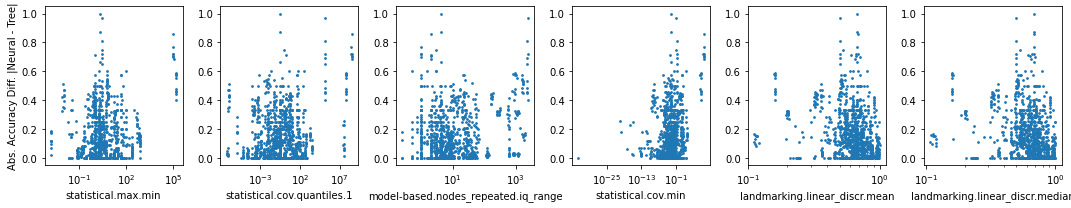

In [412]:
## plot diff abs diff with feature, for all datasets
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 6, figsize=(15, 3))

for i in range(6):
    plot_feat = feature_cols[idx_sorted_q1a[i]]
    feat_name = nice_feature_names[idx_sorted_q1a[i]]

    print(f"plotting feature {plot_feat} (corr with abs diff = {cor(df_q1[plot_feat], df_q1['abs_neural_tree_diff'])}")
    print(f"plotting feature {plot_feat} (corr with actual diff = {cor(df_q1[plot_feat], df_q1['neural_tree_diff'])}")
    print(f"(corr with actual diff = {cor(df_q1[plot_feat], df_q1['neural_tree_diff'])}")

    axs[i].scatter(df_q1[plot_feat], df_q1["abs_neural_tree_diff"], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    axs[i].set_xscale("log")

axs[0].set_ylabel(f"Abs. {metric} Diff. |Neural - Tree|")

plt.tight_layout()


## Q1.b: actual difference between neural and tree methods

In [425]:
# find correlation between each feature and abs. feat. diff

feature_cols = [c for c in df.columns if c.startswith("f__")]
nice_feature_names = [f[len("f__pymfe."):] for f in feature_cols]

target_col = "neural_tree_diff"

df = neural_tree_diff_dict["Accuracy"]

corrs = [cor(df[f], df[target_col]) for f in feature_cols]

print("highest-correlated features with ACTUAL diff:")
abs_coef = np.abs(corrs)

idx_sorted_q1b = (-abs_coef).argsort()

num_print_feats = 100

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted_q1b[i]]}: {corrs[idx_sorted_q1b[i]]}")

q1b_keep_idx = idx_sorted_q1b[:30]



highest-correlated features with ACTUAL diff:
statistical.skewness.sd: -0.32560289312375834
model-based.tree_depth.histogram.9_LOG: 0.31479395078480354
general.nr_inst_LOG: -0.31021845722754515
model-based.nodes_per_level.median_LOG: -0.30946142252038544
statistical.kurtosis.mean: -0.3069156134466626
model-based.leaves_corrob.histogram.9_LOG: 0.30577285977842844
model-based.nodes_per_level.mean_LOG: -0.30456720715450086
model-based.tree_shape.mean_LOG: 0.29603050691826044
model-based.leaves_corrob.mean_LOG: 0.29418546734507434
model-based.leaves_LOG: -0.2941853950601294
model-based.leaves_corrob.median_LOG: 0.29414153308489743
model-based.leaves_corrob.quantiles.3_LOG: 0.2933598081829534
model-based.leaves_corrob.iq_range_LOG: 0.2931833729657371
landmarking.naive_bayes.max_LOG: 0.29307060083024916
model-based.nodes_per_level.max_LOG: -0.29198272292528676
model-based.leaves_corrob.min_LOG: 0.290861098011749
model-based.leaves_corrob.quantiles.1_LOG: 0.289787560560934
statistical.skewnes

In [426]:
# which families are the highly correlated features from?
feat_families = [f.split(".")[1] for i, f in enumerate(feature_cols) if abs_coef[i] > 0.2]
pd.value_counts(feat_families)

model-based    44
statistical    39
landmarking    19
general         4
dtype: int64

In [427]:
len(feat_families)

106

plotting feature f__pymfe.statistical.skewness.sd (corr with actual diff = -0.32560289312375834
plotting feature f__pymfe.statistical.skewness.sd (corr with log-actual diff = -0.257839708665487
plotting feature f__pymfe.model-based.tree_depth.histogram.9_LOG (corr with actual diff = 0.31479395078480354
plotting feature f__pymfe.model-based.tree_depth.histogram.9_LOG (corr with log-actual diff = nan


KeyError: 'f__pymfe.model-based.tree_depth.histogram.9_LOGf__pymfe.general.nr_inst_LOG'

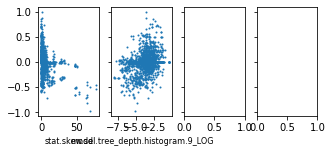

In [431]:
## plot diff real and abs diff with feature, for all datasets
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(5, 2))

plot_feats = [
    # "f__pymfe.statistical.skewness.mean",
    # "f__pymfe.statistical.kurtosis.mean",
    # "f__pymfe.model-based.tree_shape.skewness",
    "f__pymfe.statistical.skewness.sd",
    "f__pymfe.model-based.tree_depth.histogram.9_LOG",
    "f__pymfe.model-based.tree_depth.histogram.9_LOG"
    "f__pymfe.general.nr_inst_LOG",
]

for i, plot_feat in enumerate(plot_feats):
    # plot_feat = feature_cols[idx_sorted_q1b[i]]
    # feat_name = nice_feature_names[idx_sorted_q1b[i]]
    feat_name = plot_feat[len("f__pymfe."):].replace("skewness", "skew").replace("statistical", "stat").replace("model-based", "model")

    print(f"plotting feature {plot_feat} (corr with actual diff = {cor(df_q1[plot_feat], df_q1['neural_tree_diff'])}")
    print(f"plotting feature {plot_feat} (corr with log-actual diff = {cor(np.log(df_q1[plot_feat]), df_q1['neural_tree_diff'])}")

    axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=1)

    axs[i].set_xlabel(feat_name, fontsize=8)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # axs[i].set_xscale("log")

axs[0].set_ylabel("$\Delta^{Acc}$ (Neural - GBDT)") #, fontname='Serif')

plt.savefig("./results/scatter_delta_nn_gbdt.pdf", bbox_inches="tight")
plt.tight_layout()


In [292]:
# # now plot a curated version 

# plot_feats = [
#     "f__pymfe.statistical.skewness.mean",
#     "f__pymfe.statistical.kurtosis.mean",
#     "f__pymfe.model-based.tree_shape.skewness",
# ]


# fig, axs = plt.subplots(1, len(plot_feats), figsize=(10, 3))

# for i, f in enumerate(plot_feats):
#     # plot_feat = plot_feats[f]
#     feat_name = f[len("f__pymfe."):]

#     print(f"plotting feature {f} (corr with actual diff = {cor(df_q1[f], df_q1['neural_tree_diff'])}")
#     print(f"plotting feature {f} (corr with log-actual diff = {cor(np.log(df_q1[f]), df_q1['neural_tree_diff'])}")

#     axs[i].scatter(df_q1[f], df_q1["neural_tree_diff"], s=3)

#     axs[i].set_xlabel(feat_name)
#     # ax.legend()
#     # ax.set_xlabel(feat_comparison[0])
#     # ax.set_ylabel(feat_comparison[1])

#     axs[i].set_xscale("log")

# axs[0].set_ylabel(f"{metric} diff. (Neural - Tree)")

# plt.tight_layout()

plotting feature f__pymfe.landmarking.naive_bayes.max (corr with actual diff = 0.29141106146280127
plotting feature f__pymfe.landmarking.naive_bayes.max (corr with log-actual diff = 0.3130543621951824
plotting feature f__pymfe.landmarking.linear_discr.max (corr with actual diff = 0.26716838498495576
plotting feature f__pymfe.landmarking.linear_discr.max (corr with log-actual diff = 0.28322944364727415
plotting feature f__pymfe.landmarking.elite_nn.max (corr with actual diff = 0.0362978131829552
plotting feature f__pymfe.landmarking.elite_nn.max (corr with log-actual diff = 0.08746160332611148
plotting feature f__pymfe.landmarking.worst_node.max (corr with actual diff = 0.15689965218349566
plotting feature f__pymfe.landmarking.worst_node.max (corr with log-actual diff = 0.1524699161668039


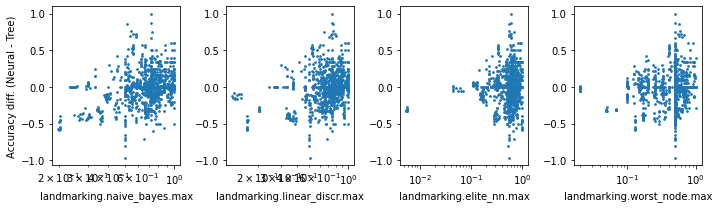

In [407]:
# now plot a curated version 

plot_feats = [
    "f__pymfe.landmarking.naive_bayes.max",
    "f__pymfe.landmarking.linear_discr.max",
    "f__pymfe.landmarking.elite_nn.max",
    # "f__pymfe.landmarking.one_nn.min",
    "f__pymfe.landmarking.worst_node.max",
]


fig, axs = plt.subplots(1, len(plot_feats), figsize=(10, 3))

for i, f in enumerate(plot_feats):
    # plot_feat = plot_feats[f]
    feat_name = f[len("f__pymfe."):]

    print(f"plotting feature {f} (corr with actual diff = {cor(df_q1[f], df_q1['neural_tree_diff'])}")
    print(f"plotting feature {f} (corr with log-actual diff = {cor(np.log(df_q1[f]), df_q1['neural_tree_diff'])}")

    axs[i].scatter(df_q1[f], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    axs[i].set_xscale("log")

axs[0].set_ylabel(f"{metric} diff. (Neural - Tree)")

plt.tight_layout()

## Q1.c: predict diff with a tree ensemble to find important features

In [415]:

from xgboost import XGBClassifier, XGBRegressor


target_col = "neural_tree_diff"

x = df_q1[feature_cols].clip(-1e10, 1e10)
y = df_q1[target_col]

xgb_q1 = XGBRegressor(n_estimators=200, max_depth=5, early_stopping_rounds=5, use_label_encoder=False).fit(x, y)

print("xgb features with high importance:")


abs_coef = xgb_q1.feature_importances_

idx_sorted_xgb = (-abs_coef).argsort()

num_print_feats = 20

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted_xgb[i]]}: {abs_coef[idx_sorted_xgb[i]]}")

q1c_keep_idx = idx_sorted_xgb[:30]


# # split indeces according to dataset "family" ()
# train_rows = df["dataset_family"].apply(lambda x: x in train_dataset_families)
# val_rows = ~train_rows

# y_train = df.loc[train_rows, target_col].values
# x_train = df.loc[train_rows, feature_cols].values

# y_val = df.loc[val_rows, target_col].values
# x_val = df.loc[val_rows, feature_cols].values



/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:02:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


xgb features with high importance:
model-based.nodes_per_level.mean: 0.11154535412788391
model-based.leaves_corrob.histogram.0: 0.06518882513046265
landmarking.elite_nn.quantiles.1.relative: 0.05612226948142052
landmarking.one_nn.mean.relative: 0.04587296396493912
statistical.skewness.max: 0.03587508574128151
statistical.can_cor.mean: 0.02869824506342411
statistical.cor.sd: 0.026290656998753548
statistical.kurtosis.iq_range: 0.025660289451479912
landmarking.elite_nn.min.relative: 0.0224112868309021
landmarking.naiv

## For Q1: plot "winning" algs using pairs of important features

In [432]:
# combine the features identified in all previous subsections
keep = 5
q1_feat_idx = list(set(q1a_keep_idx[:keep]).union(set(q1b_keep_idx[:keep])).union(set(q1c_keep_idx[:keep])))
q1_feats = [feature_cols[i] for i in q1_feat_idx]

# find a set of all feature *families* that are identified
q1_feat_family = list(set([".".join(f.split(".")[:3]) for f in q1_feats]))

print(f"{len(q1_feat_family)} identified ({len(q1_feats)} feats.):")
for f in q1_feat_family:
    print("\"" + f + "\",")

# how many meta-features overall, from these families?
final_q1_metafeats = [c for c in feature_cols if any([fam in c for fam in q1_feat_family])]
print(f"total num. feats from these families: {len(final_q1_metafeats)}")

13 identified (15 feats.):
"f__pymfe.model-based.leaves_homo",
"f__pymfe.landmarking.elite_nn",
"f__pymfe.model-based.leaves_corrob",
"f__pymfe.landmarking.linear_discr",
"f__pymfe.statistical.t_mean",
"f__pymfe.model-based.tree_shape",
"f__pymfe.statistical.skewness",
"f__pymfe.model-based.nodes_per_level",
"f__pymfe.landmarking.naive_bayes",
"f__pymfe.statistical.max",
"f__pymfe.landmarking.one_nn",
"f__pymfe.statistical.cov",
"f__pymfe.model-based.nodes_repeated",
total num. feats from these families: 332


In [430]:
final_q1_metafeats

['f__pymfe.landmarking.elite_nn.histogram.0',
 'f__pymfe.landmarking.elite_nn.histogram.0.relative',
 'f__pymfe.landmarking.elite_nn.histogram.1',
 'f__pymfe.landmarking.elite_nn.histogram.1.relative',
 'f__pymfe.landmarking.elite_nn.histogram.2',
 'f__pymfe.landmarking.elite_nn.histogram.2.relative',
 'f__pymfe.landmarking.elite_nn.histogram.3',
 'f__pymfe.landmarking.elite_nn.histogram.3.relative',
 'f__pymfe.landmarking.elite_nn.histogram.4',
 'f__pymfe.landmarking.elite_nn.histogram.4.relative',
 'f__pymfe.landmarking.elite_nn.histogram.5',
 'f__pymfe.landmarking.elite_nn.histogram.5.relative',
 'f__pymfe.landmarking.elite_nn.histogram.6',
 'f__pymfe.landmarking.elite_nn.histogram.6.relative',
 'f__pymfe.landmarking.elite_nn.histogram.7',
 'f__pymfe.landmarking.elite_nn.histogram.7.relative',
 'f__pymfe.landmarking.elite_nn.histogram.8',
 'f__pymfe.landmarking.elite_nn.histogram.8.relative',
 'f__pymfe.landmarking.elite_nn.histogram.9',
 'f__pymfe.landmarking.elite_nn.histogram.9.r

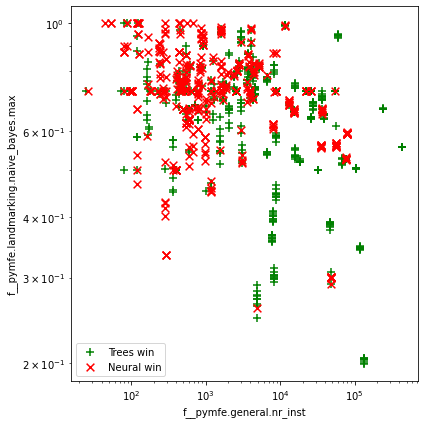

In [387]:
# plot winning-alg-class by feats...
import matplotlib.pyplot as plt

df = best_alg_df_dict["Accuracy"]

feat_comparison = [
#     "f__pymfe.statistical.mean.iq_range",
    # "f__pymfe.model-based.nodes_repeated.iq_range",     # ***
    # "f__pymfe.model-based.tree_depth.histogram.4",
#     "f__pymfe.statistical.min.quantiles.1",
    # "f__pymfe.landmarking.worst_node.sd",
#     "f__pymfe.general.freq_class.min",
    # "f__pymfe.model-based.tree_shape.sd",
    # "f__pymfe.model-based.tree_shape.skewness",
#     "f__pymfe.statistical.sd.iq_range",
    "f__pymfe.general.nr_inst",                           # ***
    # "f__pymfe.statistical.sd.min",
    # "f__pymfe.landmarking.elite_nn.min.relative",
    # "f__pymfe.model-based.var_importance.median",
    # "f__pymfe.statistical.can_cor.max",
    # "f__pymfe.statistical.can_cor.mean",
    # "f__pymfe.statistical.can_cor.median",
    # "f__pymfe.statistical.skewness.mean",
    # "f__pymfe.statistical.can_cor.quantiles.1",
    # "f__pymfe.statistical.can_cor.quantiles.3",
    # "f__pymfe.model-based.var_importance.quantiles.3",
    # "f__pymfe.statistical.skewness.sd",
    # "f__pymfe.statistical.cor.histogram.6",
    # "f__pymfe.statistical.sparsity.histogram.8",
    # "f__pymfe.statistical.cor.median",
    # "f__pymfe.statistical.cor.min",                 # **
    # "f__pymfe.landmarking.linear_discr.max",
    # "f__pymfe.landmarking.linear_discr.mean",
    # "f__pymfe.statistical.cor.sd",                # **
    # "f__pymfe.landmarking.linear_discr.median",
    # "f__pymfe.statistical.cov.histogram.0",
#     "f__pymfe.landmarking.linear_discr.min",
    # "f__pymfe.landmarking.linear_discr.quantiles.1",
    # "f__pymfe.statistical.cov.histogram.4",
    # "f__pymfe.landmarking.linear_discr.quantiles.3",
    # "f__pymfe.info-theory.attr_ent.histogram.9",
    # "f__pymfe.statistical.t_mean.histogram.6",
    # "f__pymfe.statistical.cov.iq_range",
    # "f__pymfe.statistical.t_mean.iq_range",
    # "f__pymfe.statistical.cov.max",                   # **
    # "f__pymfe.statistical.t_mean.median",
    # "f__pymfe.statistical.cov.min",                 # **
    # "f__pymfe.statistical.cov.quantiles.1",
    # "f__pymfe.statistical.t_mean.quantiles.3",
    # "f__pymfe.statistical.eigenvalues.histogram.6",
    # "f__pymfe.statistical.eigenvalues.min",             # **
    # "f__pymfe.statistical.w_lambda",
    "f__pymfe.landmarking.naive_bayes.max",         # ***
#     "f__pymfe.landmarking.naive_bayes.mean",
#     "f__pymfe.landmarking.naive_bayes.median",
    # "f__pymfe.landmarking.naive_bayes.min",
    # "f__pymfe.model-based.leaves_branch.iq_range",
#     "f__pymfe.landmarking.naive_bayes.quantiles.1",
#     "f__pymfe.landmarking.naive_bayes.quantiles.3",
#     "f__pymfe.statistical.h_mean.histogram.1",
    # "f__pymfe.model-based.leaves_corrob.histogram.0",
#     "f__pymfe.statistical.h_mean.iq_range",
    # "f__pymfe.statistical.h_mean.max",
#     "f__pymfe.statistical.h_mean.median",
#     "f__pymfe.statistical.h_mean.min",
    # "f__pymfe.statistical.h_mean.quantiles.3",
#     "f__pymfe.model-based.leaves_corrob.histogram.9",
    # "f__pymfe.statistical.iq_range.iq_range",
#     "f__pymfe.statistical.kurtosis.histogram.1",
#     "f__pymfe.model-based.leaves_homo.skewness",
    # "f__pymfe.statistical.kurtosis.iq_range",
    # "f__pymfe.statistical.kurtosis.mean",           # ***
#     "f__pymfe.statistical.kurtosis.sd",
#     "f__pymfe.statistical.mad.quantiles.3",
    # "f__pymfe.model-based.nodes_per_level.mean",      # ***
#     "f__pymfe.statistical.max.min",
    # "f__pymfe.model-based.nodes_per_level.quantiles.1",
    ######### others... #########
    # "f__pymfe.general.inst_to_attr",
    # "f__pymfe.statistical.nr_outliers",             # **
    # "f__pymfe.general.freq_class.count",
]

# feat_comparison = [
#     # "f__pymfe.statistical.skewness.mean",
#     # "f__pymfe.statistical.kurtosis.mean",
#     "f__pymfe.statistical.skewness.sd",
#     "f__pymfe.statistical.kurtosis.sd",
# ]

alg_type = df["alg_type"].astype(str).values
x = df[feat_comparison[0]].values
y = df[feat_comparison[1]].values


fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# indices of each type of point
tree_wins = df["alg_type"] == {"trees"}
neural_wins = df["alg_type"] == {"neural"}
other_wins = ~(tree_wins + neural_wins)


# plot tree-only wins
ax.scatter(x[tree_wins], y[tree_wins], label="Trees win", s=60,
        marker="+",
        color="g",
)

# plot neural-only wins
ax.scatter(x[neural_wins], y[neural_wins], label="Neural win", s=60,
        marker="x",
        color="r",
)

# # plot everything else
# ax.scatter(x[other_wins], y[other_wins], label="Other", s=100,
#         marker="^",
#         color="gray",
#         alpha=0.2,
# )


ax.legend()
ax.set_xlabel(feat_comparison[0])
ax.set_ylabel(feat_comparison[1])

ax.set_yscale("log")
ax.set_xscale("log")

plt.tight_layout()


# Q2: Can we predict when baselines will perform well, regardless of whether other alg classes perform well.

In [40]:
# # create a train/val split based on dataset family.
# dataset_families = list(best_alg_df_dict['Accuracy']['dataset_family'].unique())
# print(f"number of dataset families: {len(best_alg_df_dict['Accuracy']['dataset_family'].unique())}")

# # randomly select 10 dataset families for validation
# seed = 0
# num_val_families = 12
# rs = np.random.RandomState(seed)
# val_inds = rs.choice(len(dataset_families), num_val_families)
# val_dataset_families = [dataset_families[i] for i in val_inds]
# train_dataset_families = [d for d in dataset_families if d not in val_dataset_families]


number of dataset families: 171


In [207]:
# first, train an XGB model to get an idea of how easy/hard this question is
from xgboost import XGBClassifier

metric = "Accuracy"
df = best_alg_df_dict[metric]

target_col = "neural_win"
feature_cols = [c for c in df.columns if c.startswith("f__")]
nice_feature_names = [f[len("f__pymfe."):] for f in feature_cols]

# split indeces according to dataset "family" ()
train_rows = df["dataset_family"].apply(lambda x: x in train_dataset_families)
val_rows = ~train_rows

y_train = df.loc[train_rows, target_col].values
x_train = df.loc[train_rows, feature_cols].values

y_val = df.loc[val_rows, target_col].values
x_val = df.loc[val_rows, feature_cols].values

# assess y
print(f"number of cases with y=1 (train): {sum(y_train==1)} of {len(y_train)} ({100. * sum(y_train==1) / len(y_train):.2f}%)")
print(f"number of cases with y=1 (val): {sum(y_val==1)} of {len(y_val)} ({100. * sum(y_val==1) / len(y_val):.2f}%)")


number of cases with y=1 (train): 972 of 1585 (61.32%)
number of cases with y=1 (val): 66 of 120 (55.00%)


In [208]:
xgb_q1 = XGBClassifier(n_estimators=150, max_depth=5, early_stopping_rounds=5, use_label_encoder=False).fit(x_train, y_train)

[16:53:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:53:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [209]:
from sklearn import metrics

yhat_val = xgb_q1.predict_proba(x_val)[:, 1]
yhat_class_val = xgb_q1.predict(x_val)
yhat_train = xgb_q1.predict_proba(x_train)[:, 1]
yhat_class_train = xgb_q1.predict(x_train)


# evaluate on train and val set
auc_val = metrics.roc_auc_score(y_val, yhat_val)
auc_train = metrics.roc_auc_score(y_train, yhat_train)
f1_val = metrics.f1_score(y_val, yhat_class_val)
f1_train = metrics.f1_score(y_train, yhat_class_train)
acc_val = metrics.accuracy_score(y_val, yhat_class_val)
acc_train = metrics.accuracy_score(y_train, yhat_class_train)
# tn_val, fp_val, fn_val, tp_val = metrics.confusion_matrix(y_val, yhat_class_val).ravel()
# tn_train, fp_train, fn_train, tp_train = metrics.confusion_matrix(y_train, yhat_class_train).ravel()

print(f"ROC-AUC (val): {auc_val:.2f} | (train): {auc_train:.2f}")
print(f"F1      (val): {f1_val:.2f} | (train): {f1_train:.2f}")
print(f"Acc.    (val): {acc_val:.2f} | (train): {acc_train:.2f}")
print("val. classification report:")
print(metrics.classification_report(y_val, yhat_class_val))
print("test. classification report:")
print(metrics.classification_report(y_train, yhat_class_train))
# print(f"TP/FP   (val): {tp_val:.2f}/{fp_val:.2f} | (train): {tp_train:.2f}/{fp_train:.2f}")
# print(f"TN/FN   (val): {tn_val:.2f}/{fn_val:.2f} | (train): {tn_train:.2f}/{fn_train:.2f}")

ROC-AUC (val): 0.78 | (train): 1.00
F1      (val): 0.76 | (train): 0.99
Acc.    (val): 0.74 | (train): 0.99
val. classification report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        54
           1       0.78      0.74      0.76        66

    accuracy                           0.74       120
   macro avg       0.74      0.74      0.74       120
weighted avg       0.74      0.74      0.74       120

test. classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       613
           1       0.99      1.00      0.99       972

    accuracy                           0.99      1585
   macro avg       0.99      0.99      0.99      1585
weighted avg       0.99      0.99      0.99      1585



In [210]:
print("xgb-identified features:")
abs_coef = xgb_q1.feature_importances_

idx_sorted_xgb = (-abs_coef).argsort()
# threshold = importance[idx_third] + 0.01

num_print_feats = 30

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted_xgb[i]]}: {abs_coef[idx_sorted_xgb[i]]}")
# for 
# # 
# idx_features = (-importance).argsort()
# name_features = np.array(feature_names)[idx_features]
# print('Selected features: {}'.format(name_features))

xgb-identified features:
landmarking.one_nn.median.relative: 0.027431461960077286
landmarking.elite_nn.quantiles.1.relative: 0.027193468064069748
general.freq_class.count: 0.024279464036226273
landmarking.random_node.mean.relative: 0.019677041098475456
statistical.sparsity.min: 0.019201286137104034
landmarking.naive_bayes.sd.relative: 0.018676908686757088
general.nr_attr: 0.018481964245438576
statistical.sparsity.quantiles.3: 0.017602121457457542
landmarking.linear_discr.quantiles.3.relative: 0.017291834577918053
general.freq_class.histogram.5: 0.016498100012540817
statistical.sparsity.histogram.7: 0.016137531027197838
general.nr_inst: 0.01572916842997074
landmarking.one_nn.max.relative: 0.01548838336020708
landmarking.naive_bayes.quantiles.1.relative: 0.015343224629759789
landmarking.best_node.skewness.relative: 0.01252127904444933
landmarking.linear_discr.median.relative: 0.012494637630879879
statistical.gravity: 0.01246301457285881
landmarking.random_node.max.relative: 0.01077640708

## Identify important features using lasso

In [211]:
# also train a lasso regression 

# run a lasso regression on accuracy using dataset metafeatures
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression

# clf = LassoCV(cv=3, random_state=0).fit(x, y)
lasso = LogisticRegression(penalty="l1", solver="saga", max_iter=5000, C=1e1).fit(x_train, y_train)

In [212]:
print("lasso-identified features:")
abs_coef = np.abs(lasso.coef_)[0]

idx_sorted_lasso = (-abs_coef).argsort()
# threshold = importance[idx_third] + 0.01

num_print_feats = 10

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted_lasso[i]]}: {abs_coef[idx_sorted_lasso[i]]}")
# for 
# # 
# idx_features = (-importance).argsort()
# name_features = np.array(feature_names)[idx_features]
# print('Selected features: {}'.format(name_features))

lasso-identified features:
statistical.gravity: 1.1875881008935095e-16
statistical.cor.count: 2.4603405901952634e-23
general.nr_inst: 5.281080863948964e-25
general.inst_to_attr: 3.12924053199968e-26
general.nr_attr: 6.2353677483366965e-27
statistical.nr_outliers: 5.223636105767312e-27
statistical.h_mean.count: 2.067390890481986e-27
info-theory.attr_conc.count: 6.205766276143988e-28
landmarking.best_node.count: 1.9230540226562956e-28
landmarking.worst_node.histogram.5.relative: 1.5618529615982203e-28


## Visualize Important features

In [132]:
# hand-picked liist of important features...
important_feats = [
    "statistical.gravity",
    "general.nr_inst",
    "general.inst_to_attr",
    "statistical.nr_outliers",
    "general.freq_class.count", # start xgb feats
    "statistical.sparsity.histogram.0",
]

KeyError: "{'neural', 'trees'}"

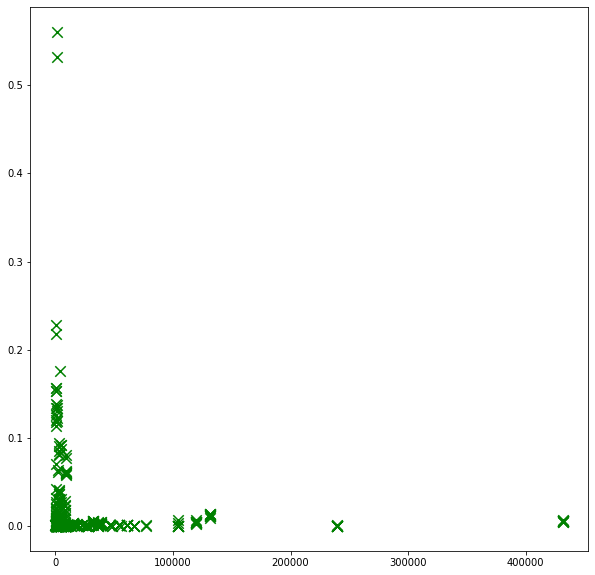

In [386]:
# plot winning-alg-class by feats...
import matplotlib.pyplot as plt

df = best_alg_df_dict["Accuracy"]

feat_comparison = [
    # "statistical.gravity",
    "general.nr_inst",
    # "general.inst_to_attr",
    # "statistical.nr_outliers",
    "statistical.cor.min",
    # "general.freq_class.count", # start xgb feats
    # "statistical.sparsity.histogram.0",
]

alg_type = df["alg_type"].astype(str).values
x = df["f__pymfe." + feat_comparison[0]].values
y = df["f__pymfe." + feat_comparison[1]].values

x_std = np.std(x)
y_std = np.std(y)

x_jit = x  # + np.random.rand(len(x)) * x_std * 0.001
y_jit = y  # + np.random.rand(len(y)) * y_std * 0.001

style_dict = {
    "{'neural'}": {
        "marker": "x",
        "color": "blue",
        },
    "{'trees', 'neural'}": {
        "marker": "*",
        "color": "purple",
        },
    "{'neural', 'baseline'}": {
        "marker": "+",
        "color": "blue",
         },
    "{'trees', 'neural', 'baseline'}": {
        "marker": "+",
        "color": "red",
        },
    "{'trees', 'baseline'}": {
        "marker": "+",
        "color": "green",
        },
    "{'baseline'}": {
        "marker": "+",
        "color": "black",
        },
    "{'trees'}": {
        "marker": "x",
        "color": "green",
    },
}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for t in set(alg_type):
    type_inds = alg_type == t

    ax.scatter(x_jit[type_inds], y_jit[type_inds], label=t, s=110, **style_dict[t])

ax.legend()
ax.set_xlabel(feat_comparison[0])
ax.set_ylabel(feat_comparison[1])

ax.set_yscale("log")
ax.set_xscale("log")

plt.tight_layout()
